IMPORTANT NOTE:

I mustve fucked up the indexing when saving the information in the final candidate models bc the 40th epoch for individual contents is not the key epoch_40 in the corresponding dictionary and the f1 score of that epoch is nowhere to be found. in short, the info about the 39th epoch is saved as epoch 40 and the info for epoch 40 is not saved at all.

Same thing with macor determinants, the max f1 score is in the last eepoch but it was not saved



In [1]:
def grid_dicto_to_df_list(grid_list):
    list_to_df = []
    non_metrics = ['proba_outputs', 'actual_classes', 'proba_outputs', 'actual_classes', 'test_proba', 'test_actual_classes']
    for dict_hyper in grid_list:
        dict_to_df = {}
        # print(dict_hyper)
        for val in dict_hyper.values():
            for item in val.items():
                if type(item[1]) != dict:
                    dict_to_df[item[0]] = item[1]
                else:
                    dictionary_results = item[1]
                    for item in dictionary_results.items(): 
                        if item[0] not in non_metrics:
                            dict_to_df[item[0]] = item[1]
        list_to_df.append(dict_to_df)
    return list_to_df

# Initial grid analysis of INDIVIDUAL DETERMINANT models

In [2]:
import pandas as pd 
import json
import pprint

In [4]:
with open("metrics_ind_dets_final.json") as f:
    grids = json.load(f)

In [5]:
len(grids)

2

In [6]:
list_to_df = grid_dicto_to_df_list(grids)

In [7]:
df = pd.DataFrame(list_to_df)

In [1248]:
# pprint.pprint(list(df.columns))

In [8]:
df.head()

,max-len,learning_rate,batch_size,num_train_epochs,n_epochs,train_loss_epoch_1,valid_loss_epoch_1,f1_epoch_1,accuracy_epoch_1,roc_auc_epoch_1,...,accuracy_epoch_40,roc_auc_epoch_40,hamming_epoch_40,proba_outputs_epoch_40,actual_classes_epoch_40,test_loss,test_f1,test_roc_auc,test_hamming,test_accuracy
0,128,0.00003,8,40,41,0.010585,0.057931,0.0,0.0,0.5,...,0.416667,0.732320,0.044753,"[[[0.0026964698918163776, 0.001964307157322764...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.066199,0.555556,0.712940,0.044444,0.40
1,128,0.00005,8,40,41,0.009303,0.048020,0.0,0.0,0.5,...,0.472222,0.741749,0.047840,"[[[0.001120816683396697, 0.0012313977349549532...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.089186,0.461538,0.685266,0.058333,0.35


In [9]:
def get_best_scores(df):

    cols_min = [ "train_loss_epoch", "valid_loss_epoch", "hamming_epoch"]

    for col in cols_min:
        filter_df = df.filter(regex=(col))
        # print(filter_df)
        minimum = filter_df.min(axis=1)
        
        name = col.split("epoch")[0]
        name_col = "best_{}".format(name)
        # print(minimum)
        df[name_col] = minimum
        
    cols_max = ["f1_epoch", "accuracy_epoch", "roc_auc_epoch"]
    
    for col in cols_max:
        filter_df = df.filter(regex=(col))
        max_ = filter_df.max(axis=1)
        name = col.split("epoch")[0]
        name_col = "best_{}".format(name)
        df[name_col] = max_
    
    return df

In [10]:
df_bests = get_best_scores(df)

In [11]:
names_cols = [col for col in df.columns if "best_" in col and "roc" not in col]

In [1253]:
names_cols

['best_train_loss_',
 'best_valid_loss_',
 'best_hamming_',
 'best_f1_',
 'best_accuracy_']

In [12]:
filter_columns = ["learning_rate", "batch_size", "test_loss", "test_f1", "test_hamming"] + names_cols

## Comparing model performance

In [13]:
df_bests[filter_columns].sort_values(["best_valid_loss_"], ascending=True)

,learning_rate,batch_size,test_loss,test_f1,test_hamming,best_train_loss_,best_valid_loss_,best_hamming_,best_f1_,best_accuracy_
0,0.00003,8,0.066199,0.555556,0.044444,0.000439,0.034903,0.041667,0.608696,0.444444
1,0.00005,8,0.089186,0.461538,0.058333,0.000230,0.036066,0.044753,0.602740,0.472222


<!-- We can see that generally the lower the batch size the faster a model will learn and the better a model will perform.

We can scratch bath size 64 since we would need a higher learning rate and we may lose control of the pace of learning.  -->

## Visualizing the candidate models

In [19]:
model_5_batch_8 = df.iloc[0]
model_3_batch_8 = df.iloc[1]

In [20]:
model_3_batch_8.keys()

Index(['max-len', 'learning_rate', 'batch_size', 'num_train_epochs',
       'n_epochs', 'train_loss_epoch_1', 'valid_loss_epoch_1', 'f1_epoch_1',
       'accuracy_epoch_1', 'roc_auc_epoch_1',
       ...
       'test_f1', 'test_roc_auc', 'test_hamming', 'test_accuracy',
       'best_train_loss_', 'best_valid_loss_', 'best_hamming_', 'best_f1_',
       'best_accuracy_', 'best_roc_auc_'],
      dtype='object', length=343)

In [23]:
df

,max-len,learning_rate,batch_size,num_train_epochs,n_epochs,train_loss_epoch_1,valid_loss_epoch_1,f1_epoch_1,accuracy_epoch_1,roc_auc_epoch_1,...,test_f1,test_roc_auc,test_hamming,test_accuracy,best_train_loss_,best_valid_loss_,best_hamming_,best_f1_,best_accuracy_,best_roc_auc_
0,128,0.00003,8,40,41,0.010585,0.057931,0.0,0.0,0.5,...,0.555556,0.712940,0.044444,0.40,0.000439,0.034903,0.041667,0.608696,0.444444,0.745050
1,128,0.00005,8,40,41,0.009303,0.048020,0.0,0.0,0.5,...,0.461538,0.685266,0.058333,0.35,0.000230,0.036066,0.044753,0.602740,0.472222,0.754479


Little function to get the info that we want to plot

In [24]:
def get_train_val_metric_df(model):
    
    """Turn a row into a more easily plot-able df 
    
    """
    
    train_loss = [model[col] for col in model.keys() if "train_loss_" in str(col) and "best" not in str(col)]    
    valid_loss = [model[col] for col in model.keys() if "valid_loss_" in str(col) and "best" not in str(col)]
    metric = [model[col] for col in model.keys() if "hamming_epoch" in str(col) and "best" not in str(col)]
    epochs = [n for n in range(1,41)]

    train_df = pd.DataFrame(train_loss, columns=["train_loss"], index=epochs)
    val_df = pd.DataFrame(valid_loss, columns=["valid_loss"], index=epochs)
    metric_df = pd.DataFrame(metric, columns=["hamming"], index=epochs)
    epochs_df = pd.DataFrame(epochs, columns=["epoch"], index=epochs)
    
    df_evaluate = pd.concat([train_df, val_df, metric_df, epochs_df], axis=1)
    
    return df_evaluate

In [25]:
df_model_5_batch_8 = get_train_val_metric_df(model_5_batch_8)
df_model_3_batch_8 = get_train_val_metric_df(model_3_batch_8)

#### Plots

In [37]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

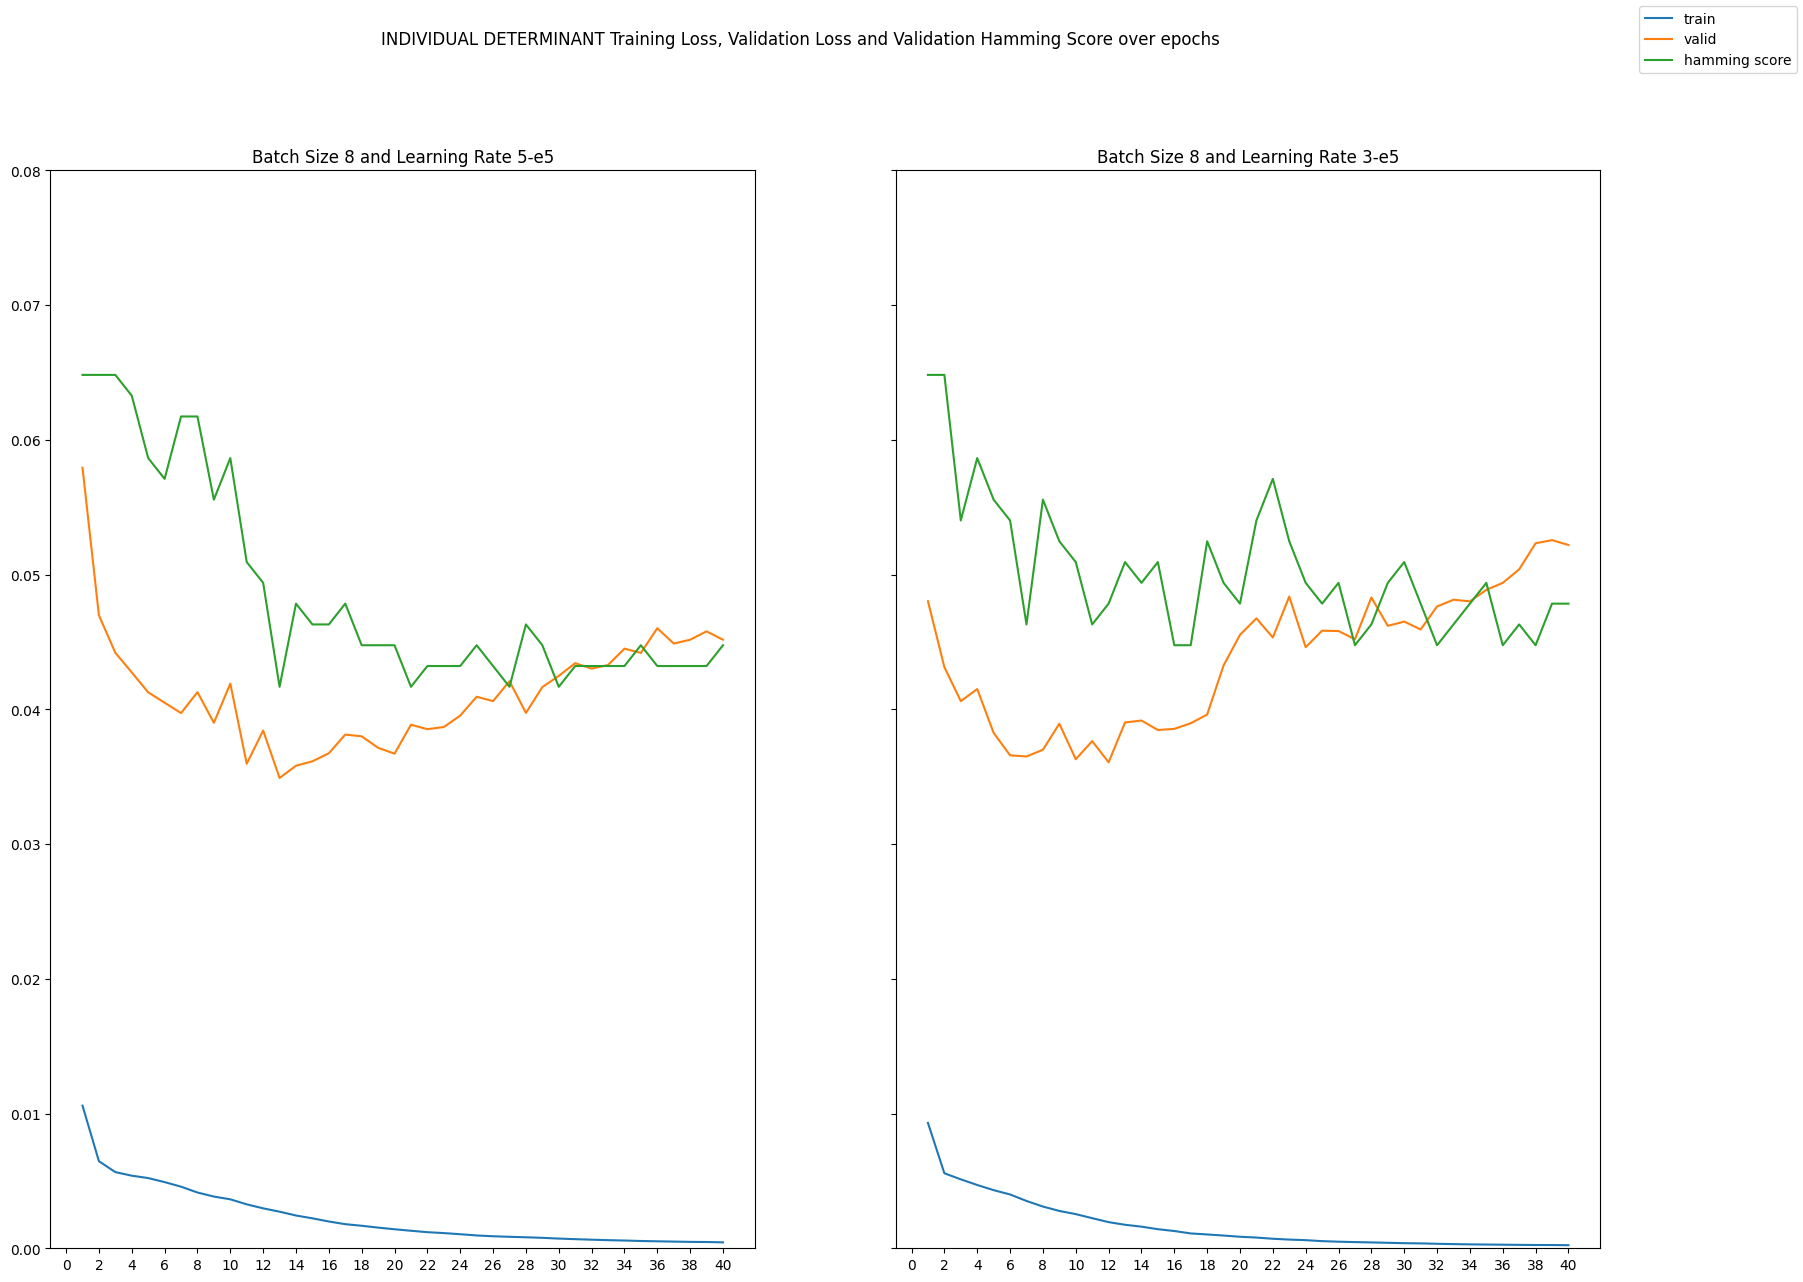

In [43]:
from matplotlib.pyplot import xticks


fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

fig.set_figheight(14)
fig.set_figwidth(20)
fig.suptitle("INDIVIDUAL DETERMINANT Training Loss, Validation Loss and Validation Hamming Score over epochs")

ax[0].set_ylim(0, 0.08)

ax[0].title.set_text("Batch Size 8 and Learning Rate 5-e5")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["train_loss"], label="train")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["valid_loss"], label="valid")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["hamming"], label="hamming score")

ax[1].set_ylim(0, 0.08)

ax[1].title.set_text("Batch Size 8 and Learning Rate 3-e5")
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["train_loss"])
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["valid_loss"])
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["hamming"])
xticks(np.arange(0, 41, 2))

fig.legend()
plt.show()

# Initial grid analysis of INDIVIDUAL CONTENT models

In [94]:
with open("metrics_ind_conts_final.json") as f:
    grids = json.load(f)

In [95]:
len(grids)

2

In [101]:
grids[0]["metrics"]["epoch_40"]

{'train_loss_epoch_40': 0.0006103789043845609,
 'valid_loss_epoch_40': 0.014649847108456822,
 'f1_epoch_40': 0.6666666666666666,
 'accuracy_epoch_40': 0.5365853658536586,
 'roc_auc_epoch_40': 0.8130168606985146,
 'hamming_epoch_40': 0.02710027100271003,
 'proba_outputs_epoch_40': [[[0.009461550042033195,
    0.034165509045124054,
    0.021920567378401756,
    0.006592131685465574,
    0.022349555045366287,
    0.025353407487273216,
    0.013287708163261414,
    0.005035874433815479,
    0.02760644070804119,
    0.006228554993867874,
    0.004361510276794434,
    0.009476796723902225,
    0.0084144975990057,
    0.00484441826120019,
    0.009037366136908531,
    0.01333190780133009,
    0.007857732474803925,
    0.004133068956434727,
    0.004471770487725735,
    0.9717338681221008,
    0.005642820615321398,
    0.004081104416400194,
    0.004012600518763065,
    0.00172831816598773,
    0.008066339418292046,
    0.003677512751892209,
    0.005370557773858309],
   [0.0047766887582838535

In [85]:
list_to_df = grid_dicto_to_df_list(grids)

In [86]:
df = pd.DataFrame(list_to_df)

In [87]:
df.columns

Index(['max-len', 'learning_rate', 'batch_size', 'num_train_epochs',
       'n_epochs', 'train_loss_epoch_1', 'valid_loss_epoch_1', 'f1_epoch_1',
       'accuracy_epoch_1', 'roc_auc_epoch_1',
       ...
       'accuracy_epoch_40', 'roc_auc_epoch_40', 'hamming_epoch_40',
       'proba_outputs_epoch_40', 'actual_classes_epoch_40', 'test_loss',
       'test_f1', 'test_roc_auc', 'test_hamming', 'test_accuracy'],
      dtype='object', length=337)

In [88]:
df.head()

,max-len,learning_rate,batch_size,num_train_epochs,n_epochs,train_loss_epoch_1,valid_loss_epoch_1,f1_epoch_1,accuracy_epoch_1,roc_auc_epoch_1,...,accuracy_epoch_40,roc_auc_epoch_40,hamming_epoch_40,proba_outputs_epoch_40,actual_classes_epoch_40,test_loss,test_f1,test_roc_auc,test_hamming,test_accuracy
0,128,0.00003,8,40,41,0.011640,0.048609,0.0,0.0,0.5,...,0.536585,0.813017,0.027100,"[[[0.009461550042033195, 0.034165509045124054,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.019439,0.765957,0.870812,0.017713,0.652174
1,128,0.00005,12,40,41,0.018132,0.072115,0.0,0.0,0.5,...,0.463415,0.769992,0.031617,"[[[0.006345027592033148, 0.016668369993567467,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.032663,0.666667,0.826633,0.025765,0.565217


In [89]:
df_bests = get_best_scores(df)

## Comparing model performance

In [90]:
df_bests[filter_columns].sort_values("test_loss", ascending=True)

,learning_rate,batch_size,test_loss,test_f1,test_hamming,best_train_loss_,best_valid_loss_,best_hamming_,best_f1_,best_accuracy_
0,0.00003,8,0.019439,0.765957,0.017713,0.000610,0.014260,0.02710,0.666667,0.536585
1,0.00005,12,0.032663,0.666667,0.025765,0.000763,0.023557,0.02439,0.674699,0.560976


## Visualizing the candidate models

In [53]:
model_5_batch_8 = df.iloc[0]
model_3_batch_8 = df.iloc[1]

In [54]:
df_model_5_batch_8 = get_train_val_metric_df(model_5_batch_8)
df_model_3_batch_8 = get_train_val_metric_df(model_3_batch_8)

#### Plots

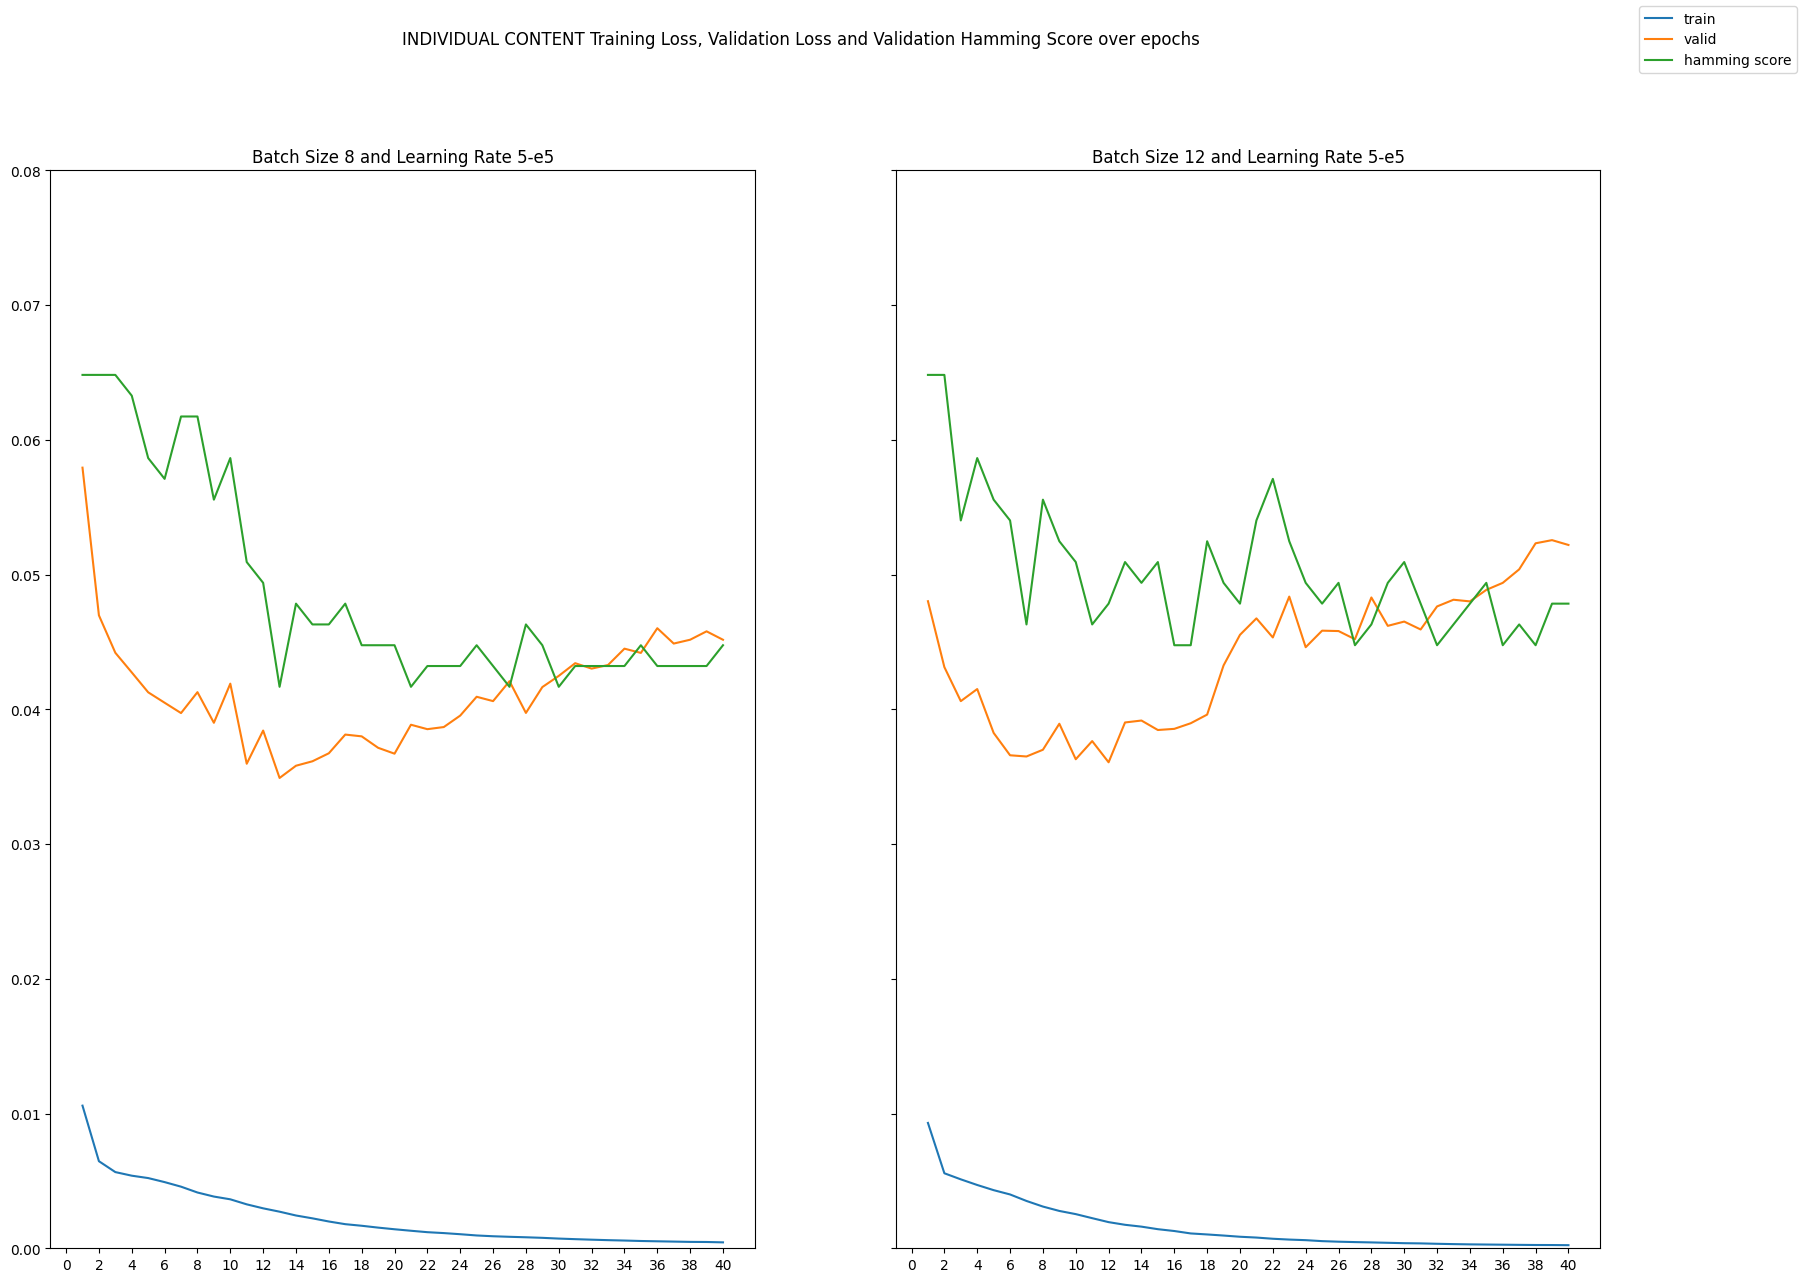

In [56]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

fig.set_figheight(14)
fig.set_figwidth(20)
fig.suptitle("INDIVIDUAL CONTENT Training Loss, Validation Loss and Validation Hamming Score over epochs")

ax[0].set_ylim(0, 0.08)

ax[0].title.set_text("Batch Size 8 and Learning Rate 5-e5")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["train_loss"], label="train")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["valid_loss"], label="valid")
ax[0].plot(df_model_5_batch_8.index, df_model_5_batch_8["hamming"], label="hamming score")

ax[1].set_ylim(0, 0.08)

ax[1].title.set_text("Batch Size 12 and Learning Rate 5-e5")
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["train_loss"])
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["valid_loss"])
ax[1].plot(df_model_3_batch_8.index, df_model_3_batch_8["hamming"])

xticks(np.arange(0, 41, 2))

fig.legend()
plt.show()

# Initial grid analysis of MACRO DETERMINANT models

In [57]:
with open("metrics_macro_dets_final.json") as f:
    grids = json.load(f)
    
grids = grids[-9:]

In [58]:
list_to_df = grid_dicto_to_df_list(grids)

In [59]:
df = pd.DataFrame(list_to_df)

In [60]:
# df.columns

In [61]:
df.head()

,max-len,learning_rate,batch_size,num_train_epochs,n_epochs,train_loss_epoch_1,valid_loss_epoch_1,f1_epoch_1,accuracy_epoch_1,roc_auc_epoch_1,...,accuracy_epoch_40,roc_auc_epoch_40,hamming_epoch_40,proba_outputs_epoch_40,actual_classes_epoch_40,test_loss,test_f1,test_roc_auc,test_hamming,test_accuracy
0,128,0.00003,8,40,41,0.010871,0.062144,0.000000,0.000000,0.500000,...,0.722222,0.885434,0.040404,"[[[0.9964144229888916, 0.002025668742135167, 0...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.039736,0.875000,0.946906,0.025974,0.809524
1,128,0.00003,8,40,41,0.010753,0.064659,0.000000,0.000000,0.500000,...,0.750000,0.886850,0.037879,"[[[0.9955548644065857, 0.0022354640532284975, ...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.033601,0.851064,0.925167,0.030303,0.761905
2,128,0.00002,8,40,41,0.012623,0.070778,0.269231,0.194444,0.578562,...,0.722222,0.876639,0.037879,"[[[0.9907714128494263, 0.0055266437120735645, ...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.038955,0.791667,0.898620,0.043290,0.666667
3,128,0.00005,12,40,41,0.015428,0.096699,0.088889,0.055556,0.523256,...,0.722222,0.886850,0.037879,"[[[0.9964296221733093, 0.003049102844670415, 0...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.036009,0.875000,0.946906,0.025974,0.761905


In [62]:
df_best = get_best_scores(df)

## Comparing model performance

In [63]:
df_best[filter_columns].sort_values(["test_loss"], ascending=True)

,learning_rate,batch_size,test_loss,test_f1,test_hamming,best_train_loss_,best_valid_loss_,best_hamming_,best_f1_,best_accuracy_
1,0.00003,8,0.033601,0.851064,0.030303,0.000245,0.026439,0.030303,0.853659,0.777778
3,0.00005,12,0.036009,0.875000,0.025974,0.000300,0.037689,0.030303,0.853659,0.805556
2,0.00002,8,0.038955,0.791667,0.043290,0.000396,0.026354,0.037879,0.819277,0.722222
0,0.00003,8,0.039736,0.875000,0.025974,0.000233,0.024923,0.032828,0.843373,0.805556


THERE IS A WRONG ONE

## Visualizing the candidate models

In [65]:
model_3_batch_8 = df.iloc[1]
model_2_batch_8 = df.iloc[2]
model_5_batch_8 = df.iloc[0]
model_5_batch_12 = df.iloc[3]

In [66]:
df_model_3_batch_8 = get_train_val_metric_df(model_3_batch_8)
df_model_2_batch_8 = get_train_val_metric_df(model_2_batch_8)
df_model_5_batch_8 = get_train_val_metric_df(model_5_batch_8)
df_model_5_batch_12 = get_train_val_metric_df(model_5_batch_12)

#### Plots

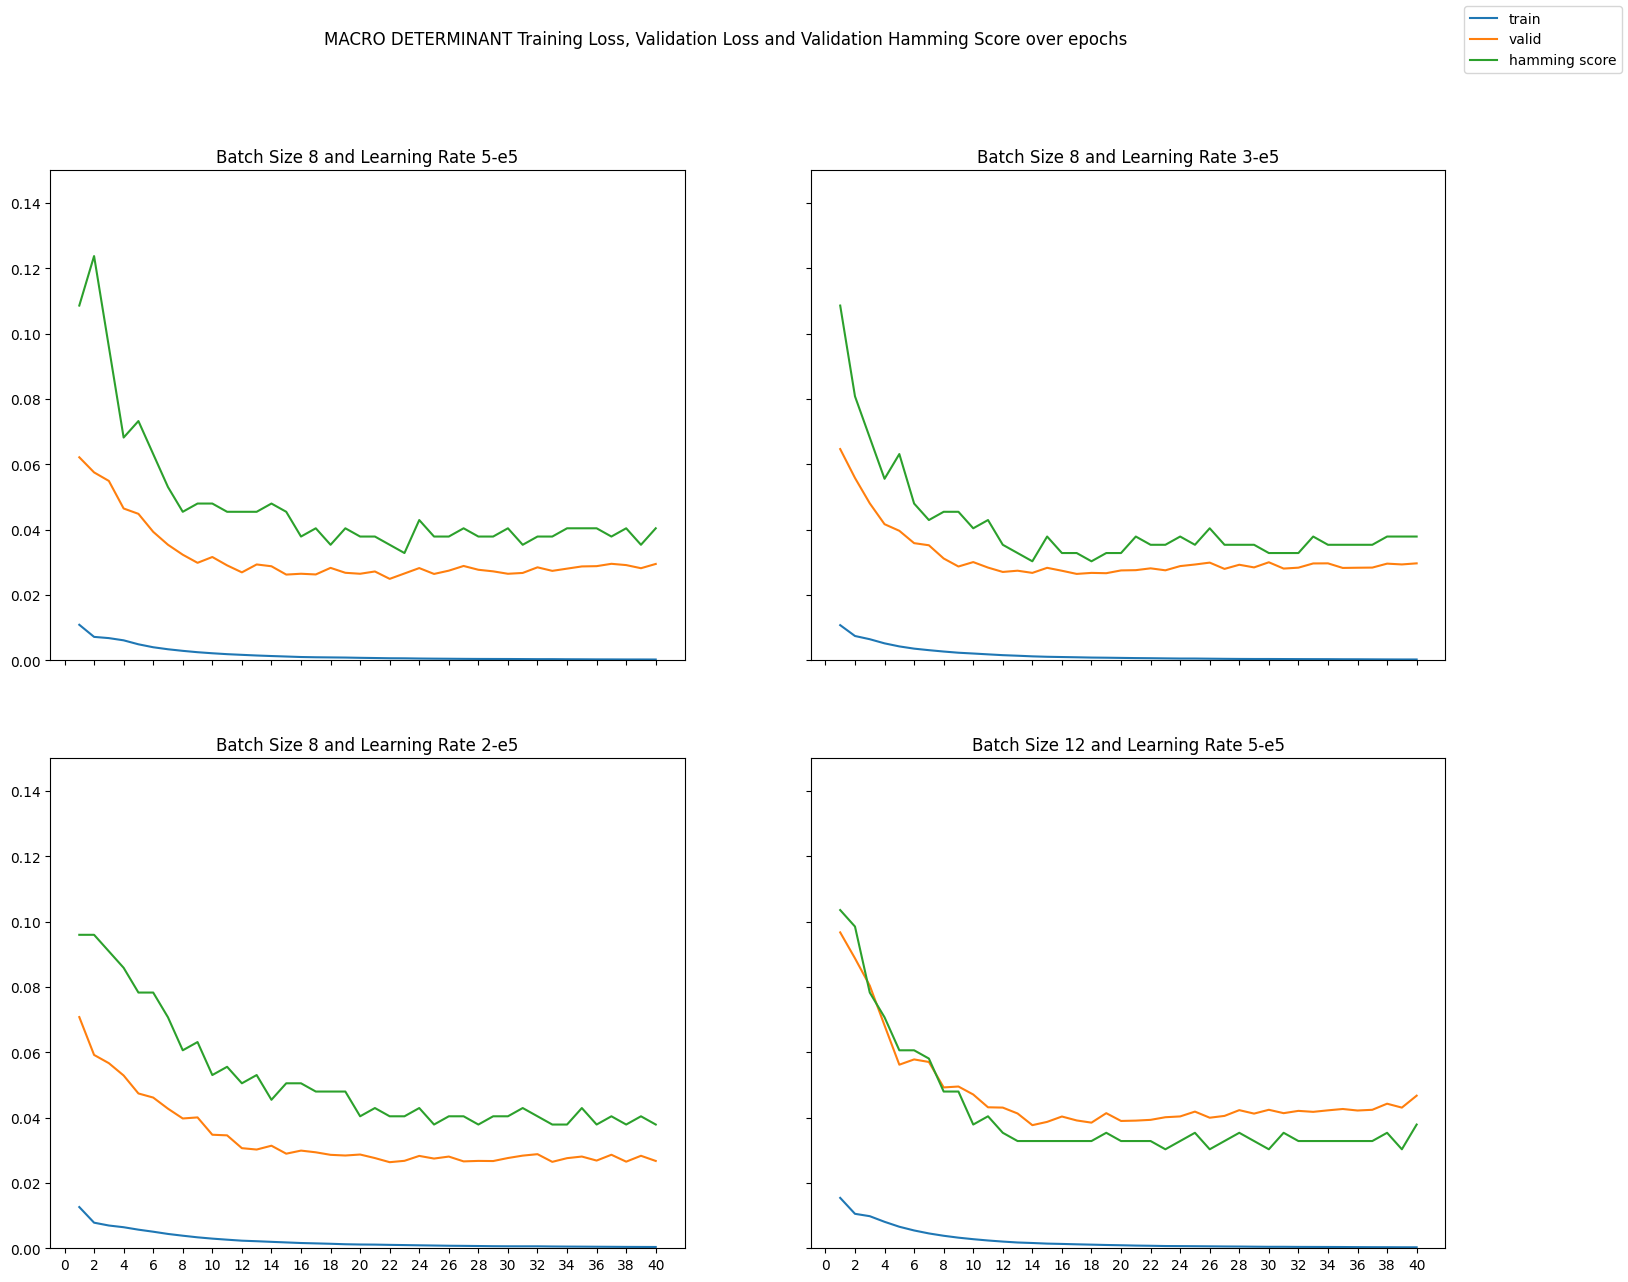

In [68]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_figheight(14)
fig.set_figwidth(18)
fig.suptitle("MACRO DETERMINANT Training Loss, Validation Loss and Validation Hamming Score over epochs")

ax[0, 0].set_ylim(0,0.15)

ax[0, 0].title.set_text("Batch Size 8 and Learning Rate 5-e5")
ax[0, 0].plot(df_model_5_batch_8.index, df_model_5_batch_8["train_loss"], label="train")
ax[0, 0].plot(df_model_5_batch_8.index, df_model_5_batch_8["valid_loss"], label="valid")
ax[0, 0].plot(df_model_5_batch_8.index, df_model_5_batch_8["hamming"], label="hamming score")


ax[0, 1].set_ylim(0,0.15)

ax[0, 1].title.set_text("Batch Size 8 and Learning Rate 3-e5")
ax[0, 1].plot(df_model_3_batch_8.index, df_model_3_batch_8["train_loss"])
ax[0, 1].plot(df_model_3_batch_8.index, df_model_3_batch_8["valid_loss"])
ax[0, 1].plot(df_model_3_batch_8.index, df_model_3_batch_8["hamming"])


ax[1, 0].set_ylim(0,0.15)

ax[1, 0].title.set_text("Batch Size 8 and Learning Rate 2-e5")
ax[1, 0].plot(df_model_2_batch_8.index, df_model_2_batch_8["train_loss"])
ax[1, 0].plot(df_model_2_batch_8.index, df_model_2_batch_8["valid_loss"])
ax[1, 0].plot(df_model_2_batch_8.index, df_model_2_batch_8["hamming"])

ax[1, 1].set_ylim(0,0.15)

ax[1, 1].title.set_text("Batch Size 12 and Learning Rate 5-e5")
ax[1, 1].plot(df_model_5_batch_12.index, df_model_5_batch_12["train_loss"])
ax[1, 1].plot(df_model_5_batch_12.index, df_model_5_batch_12["valid_loss"])
ax[1, 1].plot(df_model_5_batch_12.index, df_model_5_batch_12["hamming"])
xticks(np.arange(0, 41, 2))


fig.legend()
plt.show()

# Initial grid analysis of MACRO CONTENT models

In [70]:
with open("metrics_macro_conts_final.json") as f:
    grids = json.load(f)


In [71]:
list_to_df = grid_dicto_to_df_list(grids)

In [72]:
df = pd.DataFrame(list_to_df)

In [73]:
df.columns

Index(['max-len', 'learning_rate', 'batch_size', 'num_train_epochs',
       'n_epochs', 'train_loss_epoch_1', 'valid_loss_epoch_1', 'f1_epoch_1',
       'accuracy_epoch_1', 'roc_auc_epoch_1',
       ...
       'accuracy_epoch_40', 'roc_auc_epoch_40', 'hamming_epoch_40',
       'proba_outputs_epoch_40', 'actual_classes_epoch_40', 'test_loss',
       'test_f1', 'test_roc_auc', 'test_hamming', 'test_accuracy'],
      dtype='object', length=337)

In [74]:
df.head()

,max-len,learning_rate,batch_size,num_train_epochs,n_epochs,train_loss_epoch_1,valid_loss_epoch_1,f1_epoch_1,accuracy_epoch_1,roc_auc_epoch_1,...,accuracy_epoch_40,roc_auc_epoch_40,hamming_epoch_40,proba_outputs_epoch_40,actual_classes_epoch_40,test_loss,test_f1,test_roc_auc,test_hamming,test_accuracy
0,128,0.00002,8,40,41,0.013925,0.099629,0.000000,0.000000,0.500000,...,0.472222,0.751337,0.166667,"[[[0.021680708974599838, 0.0006303924601525068...","[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1....",0.450758,0.500000,0.664504,0.244444,0.333333
1,128,0.00005,8,40,41,0.012716,0.096289,0.254545,0.111111,0.564840,...,0.638889,0.830548,0.116667,"[[[0.004929050337523222, 0.001259887358173728,...","[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1....",0.568296,0.476190,0.650227,0.244444,0.388889
2,128,0.00005,12,40,41,0.019431,0.165172,0.122449,0.027778,0.526738,...,0.583333,0.823195,0.127778,"[[[0.0047245873138308525, 0.000634481490124017...","[[0.0, 0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 0.0, 1....",0.528355,0.465116,0.642764,0.255556,0.388889


In [75]:
df_best = get_best_scores(df)

## Comparing Model performance

In [76]:
df_best[filter_columns].sort_values(["test_loss"], ascending=True)

,learning_rate,batch_size,test_loss,test_f1,test_hamming,best_train_loss_,best_valid_loss_,best_hamming_,best_f1_,best_accuracy_
0,0.00002,8,0.450758,0.500000,0.244444,0.000169,0.085856,0.144444,0.675000,0.500000
2,0.00005,12,0.528355,0.465116,0.255556,0.000130,0.122432,0.122222,0.744186,0.611111
1,0.00005,8,0.568296,0.476190,0.244444,0.000058,0.075530,0.116667,0.752941,0.638889


In [77]:
model_2_batch_8 = df.iloc[0]
model_5_batch_8 = df.iloc[1]
model_5_batch_12 = df.iloc[2]

In [79]:
df_model_2_batch_8 = get_train_val_metric_df(model_2_batch_8)
df_model_3_batch_8 = get_train_val_metric_df(model_3_batch_8)
df_model_5_batch_12 = get_train_val_metric_df(model_5_batch_12)

#### Plots

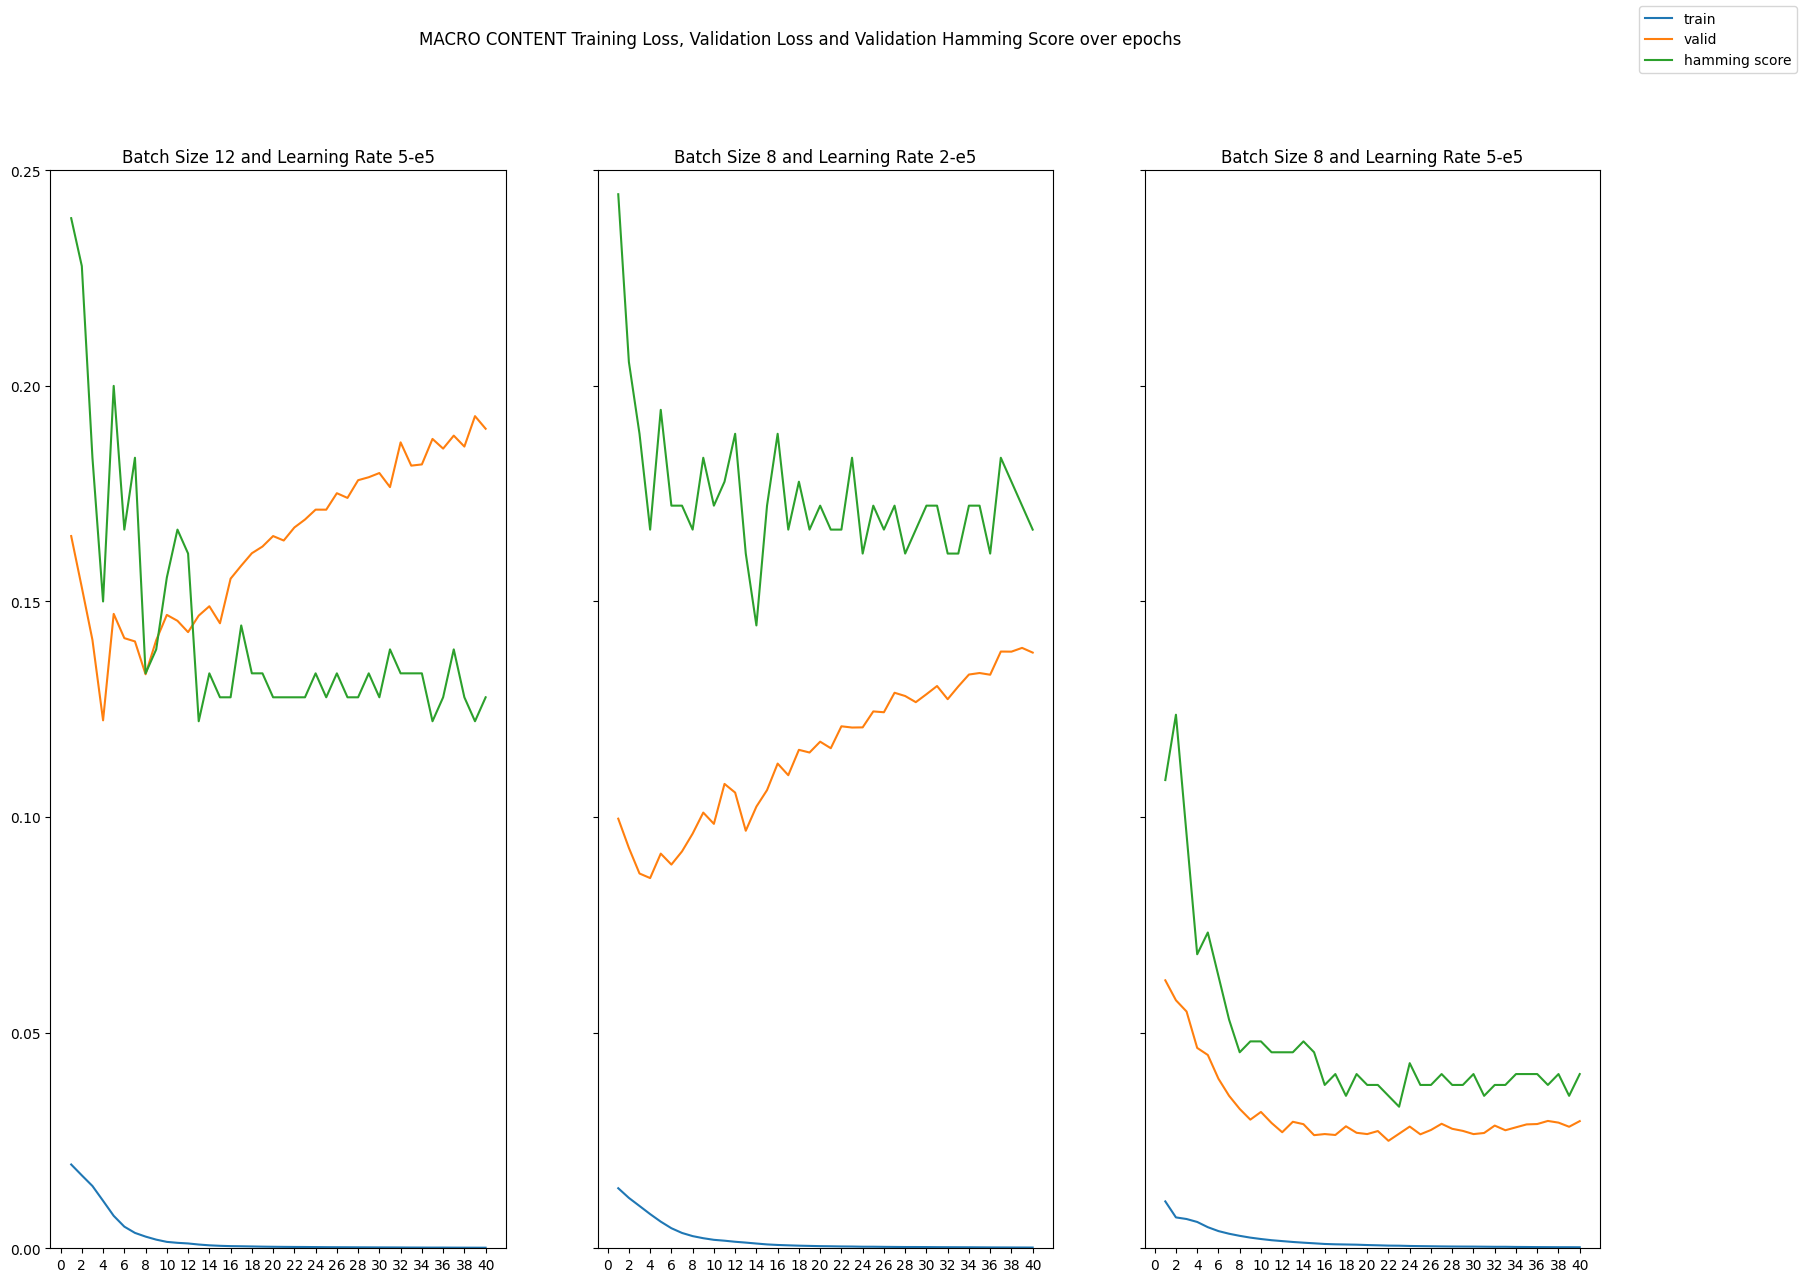

In [82]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_figheight(14)
fig.set_figwidth(20)
fig.suptitle("MACRO CONTENT Training Loss, Validation Loss and Validation Hamming Score over epochs")

ax[0].set_ylim(0,0.25)

ax[0].title.set_text("Batch Size 12 and Learning Rate 5-e5")
ax[0].plot(df_model_5_batch_12.index, df_model_5_batch_12["train_loss"], label="train")
ax[0].plot(df_model_5_batch_12.index, df_model_5_batch_12["valid_loss"], label="valid")
ax[0].plot(df_model_5_batch_12.index, df_model_5_batch_12["hamming"], label="hamming score")


ax[2].set_ylim(0,0.25)

ax[2].title.set_text("Batch Size 8 and Learning Rate 5-e5")
ax[2].plot(df_model_5_batch_8.index, df_model_5_batch_8["train_loss"])
ax[2].plot(df_model_5_batch_8.index, df_model_5_batch_8["valid_loss"])
ax[2].plot(df_model_5_batch_8.index, df_model_5_batch_8["hamming"])


ax[1].set_ylim(0,0.25)

ax[1].title.set_text("Batch Size 8 and Learning Rate 2-e5")
ax[1].plot(df_model_2_batch_8.index, df_model_2_batch_8["train_loss"])
ax[1].plot(df_model_2_batch_8.index, df_model_2_batch_8["valid_loss"])
ax[1].plot(df_model_2_batch_8.index, df_model_2_batch_8["hamming"])
xticks(np.arange(0, 41, 2))


fig.legend()
plt.show()

# OLD, KEEPING IN CASE WE NEED IT

In [1303]:
# lr_curves = df.pivot_table(["train_loss", "valid_loss"], ["max-len", "learning_rate", "batch_size"], "epoch")

In [1304]:
# lr_curves

In [1305]:
# lr_curves.iloc[0]["train_loss"]

In [1306]:
# lr_curves.iloc[0]["valid_loss"]

In [1307]:
# candidates = []

# for row, col in lr_curves.iterrows():

#     train_loss_array = col["train_loss"]
#     valid_loss_array = col["valid_loss"]
#     if valid_loss_array[2] < 0.1:
#         candidates.append(row)
#         print("train_loss", train_loss_array)
#         print("valid_loss", valid_loss_array)
#         print(row)
#         epochs = [2, 3, 4, 5, 6, 8]
#         fig, ax = plt.subplots()
#         ax.set_ylim(0,0.2)
#         plt.plot(epochs, train_loss_array, label="train")
#         plt.legend()
#         plt.plot(epochs, valid_loss_array, label="valid")
#         plt.legend()
#         plt.show()
#         # train_loss_array = df.iloc[]["train_loss"]
    

In [1308]:
# candidates

In [1309]:
# df[(df["batch_size"] == 8) & (df["max-len"] == 128) & (df["epoch"] == 8) ]

In [1310]:
# df.sort_values("test_hamming", ascending=True)

In [1311]:
# import seaborn as sns
# import matplotlib.pyplot as plt

In [1312]:
# # df.pivot_table("train_loss", index="batch_size", columns="epoch")
# sns.lineplot(df.pivot_table("train_loss", index="batch_size", columns="learning_rate"))
# plt.show()

In [1313]:
# df.pivot_table("val_f1", index="batch_size", columns="learning_rate")


In [1314]:
# df.pivot_table("train_loss", index="num_train_epochs", columns="batch_size")

The larger the batch size, the more epochs we need

In [1315]:
# df.pivot_table("val_loss", index="num_train_epochs", columns="learning_rate")

The larger the learning_rate, the less epochs we need

In [1316]:
# df.pivot_table("test_f1", index="num_train_epochs", columns="learning_rate")

In [1317]:
# df.pivot_table("val_f1", index="num_train_epochs", columns="learning_rate")

Learning curve plots

dont gridsearch epoch